In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dask
import dask.array as da
import xarray as xr

import toolbox_scs as tb
from toolbox_scs.routines.boz import load_dssc_module
from extra_data import open_run
from itertools import combinations
from itertools import repeat
from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster

import pandas as pd
from datetime import date
from tqdm.notebook import tqdm
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (14,8)
mpl.rcParams['font.size'] = 20

from os.path import basename, exists

from glob import glob
from pathlib import Path
from lmfit import Model, Parameters
from scipy.special import gamma, factorial, loggamma

In [2]:
current =    [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
runNB =      [70,  71,  73,  74,  76,  77,  79,  80,  82]
modules = [15, 0, 8, 7]
proposalNB = 2884

# single group test

In [3]:
%%time
run = runNB[0]
modno = modules[1]
index = 0
photon_maps = np.load(f'/gpfs/exfel/u/scratch/SCS/202201/p002884/LS/Reduced_Data/reduced_3-17-23/r{run:0d}m{modno:0d}_{index:1d}_photon.npy')

CPU times: user 2.23 ms, sys: 8.24 s, total: 8.24 s
Wall time: 8.45 s


In [4]:
# shape: (train_id, pulse_id, row, col)
photon_maps.shape

(300, 200, 128, 512)

In [5]:
import sys

print(f'Size of data loaded: {sys.getsizeof(photon_maps) / 1e9:.1f} GB')

Size of data loaded: 31.5 GB


## single pulse statistics (no filtering, entire group)

In [183]:
%%time
shape = photon_maps.shape
pm = photon_maps.reshape(shape[0]*shape[1], shape[2]*shape[3]).astype(int)
pm = np.maximum(0, pm)

prob_k = np.zeros((len(pm) , np.amax(pm)+1), dtype=float)
for i, p in tqdm(enumerate(pm), total=len(pm), desc='Statistics-ing'):
    counts = np.bincount(p)
    prob_k[i, :len(counts)] = counts / (shape[2]*shape[3])
    
prob_k = prob_k.reshape((*shape[:2], prob_k.shape[-1])).transpose()
k_bar = np.mean(photon_maps, axis=(2,3))

Statistics-ing:   0%|          | 0/60000 [00:00<?, ?it/s]

CPU times: user 29 s, sys: 13.5 s, total: 42.4 s
Wall time: 43.2 s


In [ ]:
%%time
from scipy.stats import gaussian_kde
x = prob_k[2].ravel()
y = k_bar.ravel()

xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

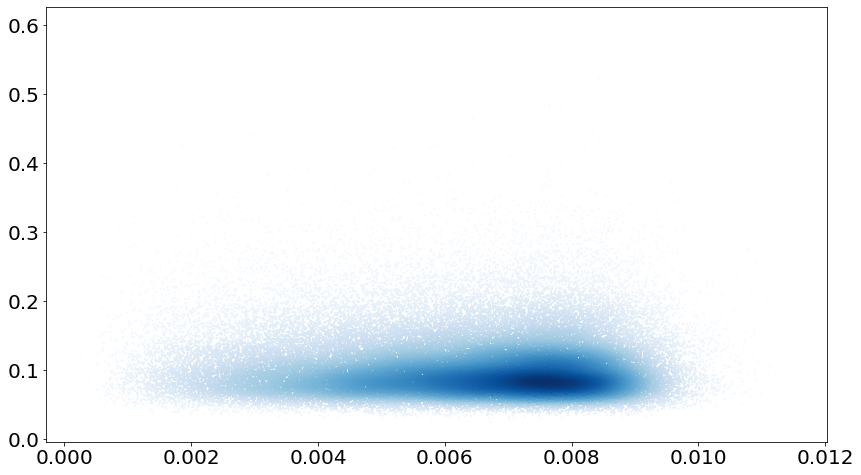

In [176]:
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=1, cmap='Blues')
plt.show()

## pair correlations (single train)

In [6]:
# single group and train raveled
train = photon_maps[0].reshape(photon_maps.shape[1], -1)
train = np.maximum(0, train)
train.shape

(200, 65536)

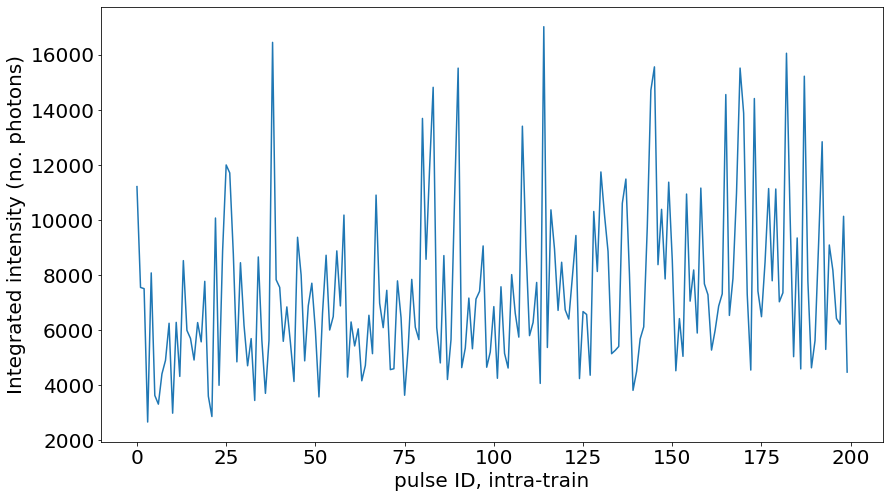

In [7]:
plt.figure()
plt.plot(np.nansum(train, axis=-1))
plt.xlabel('pulse ID, intra-train')
plt.ylabel('Integrated intensity (no. photons)')
plt.show()

In [298]:
pwd

'/gpfs/exfel/u/usr/SCS/202201/p002884/Software/ryan/post_experiment'

In [213]:
%%time
shape = photon_maps.shape
train = photon_maps[0].reshape(photon_maps.shape[1], -1)
train = np.maximum(0, train)

prob_all = np.zeros((len(train), 100,  len(train)), dtype=float) * np.nan
k_bar_all = np.zeros((len(train), len(train)), dtype=float) * np.nan
valid_pairs = np.zeros(len(train), dtype=int)

for i in tqdm(range(len(train)), total=len(train)):
    left_stack = train[:train.shape[0]-i]
    right_stack = train[i:]

    pulse_tol = 0.05
    filt = np.logical_and(np.nansum(left_stack, axis=-1)<=(1+pulse_tol)*np.nansum(right_stack, axis=-1), 
                              np.nansum(right_stack, axis=-1)<=(1+pulse_tol)*np.nansum(left_stack, axis=-1))
    #print(f'Valid pairs: {len(filt[filt==True])}')
    valid_pairs[i] = len(filt[filt==True])
    
    mask = np.load(f'./xpfs_masks/r{run:0d}_m{modno:1d}.npy').ravel()
    smd_left = left_stack[filt][..., mask==1]
    smd_right = right_stack[filt][..., mask==1]

    two_images = smd_left + smd_right

    # allow for a maximum of 100 photons in a single pixel. This is definitely overkill but 
    # should avoid any errors with shape later. prob_k dimensions: (valid pairs x probability of k photons)
    prob_k = np.zeros((100, len(two_images)), dtype=float) 

    for ii, p in enumerate(two_images.astype(int)):
        counts = np.bincount(p)
        prob_k[:len(counts), ii] = counts / (len(p[~np.isnan(p)]))

    k_bar = np.nanmean(two_images, axis=(-1))
    
    prob_all[i, :, :len(prob_k.T)] = prob_k
    k_bar_all[i, :len(k_bar)] = k_bar

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 9.28 s, sys: 3.27 s, total: 12.6 s
Wall time: 14.1 s


In [214]:
def neg_binom(k_bar, k, M):
    nb = (gamma( k + M ) / gamma( M ) / factorial( k ) ) * \
    ( ( k_bar / ( k_bar + M ) ) ** k ) * ( ( M / ( k_bar + M ) ) ** M)
    return nb

model = Model(neg_binom, independent_vars=['k_bar', 'k'])
params = Parameters()
params.add('M', value=4, min=0.1, max=150)

pulse_separation = 1
min_k = 1
max_k = 10
y = prob_all[pulse_separation, min_k:max_k+1, :]
x = np.repeat(np.expand_dims(k_bar_all[pulse_separation, :], axis=-1), len(y), axis=-1).T
k = np.outer(np.arange(min_k, max_k+1), np.ones(len(y.T))).astype(int)

out = model.fit(data=y, k_bar=x, k=k, **params, nan_policy='omit')

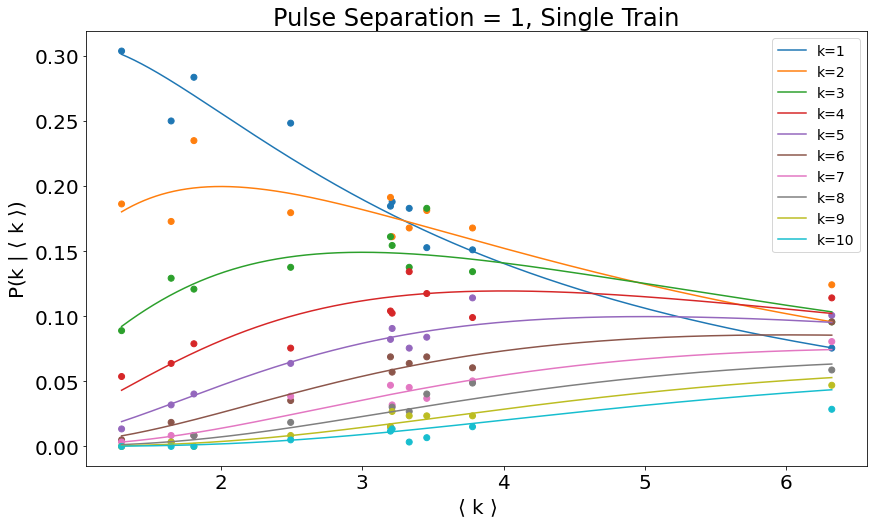

In [215]:
plt.figure()
plt.scatter(x.ravel(), y.ravel(), c=[f'C{k_-1}' for k_ in k.ravel()])

for kk in np.arange(min_k, max_k + 1):
    fit = neg_binom(xx, kk, out.best_values['M'])
    plt.plot(xx, fit, label=f'k={kk}')
    
plt.title(f'Pulse Separation = {pulse_separation}, Single Train')
plt.xlabel(r'$\langle$ k $\rangle$')
plt.ylabel(r'P(k | $\langle$ k $\rangle$)')
plt.legend(fontsize=14)
plt.show()

In [216]:
model = Model(neg_binom, independent_vars=['k_bar', 'k'])
params = Parameters()
params.add('M', value=4, min=0.1, max=150)
min_k = 1
max_k = 10

delays = []
contrasts = []
for p_sep, pulse_separation in tqdm(enumerate(range(len(train))), total=len(train), desc='Fitting Neg. Binom.'):
    y = prob_all[pulse_separation, min_k:max_k+1, :]
    x = np.repeat(np.expand_dims(k_bar_all[pulse_separation, :], axis=-1), len(y), axis=-1).T
    k = np.outer(np.arange(min_k, max_k+1), np.ones(len(y.T))).astype(int)

    if np.isnan(y).all():
        continue

    out = model.fit(data=y, k_bar=x, k=k, **params, nan_policy='omit')
    delays.append(p_sep)
    contrasts.append(1/np.sqrt(out.best_values['M']))

Fitting Neg. Binom.:   0%|          | 0/200 [00:00<?, ?it/s]

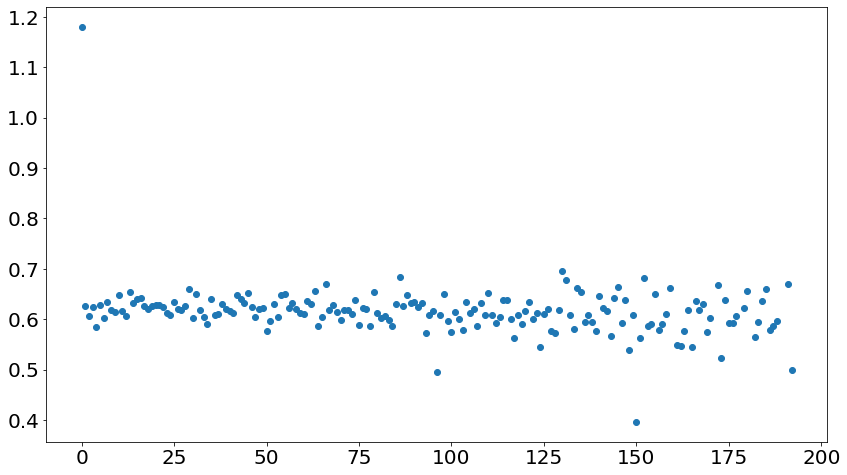

In [220]:
plt.plot(delays, contrasts, 'o')

In [271]:
def process_train(train, pulse_tol=0.05, mask=None, train_id=None, group_id=None, field=None, run=None, module=None):
    # takes in a single train and returns an xarray dataset containing the photon statistics. No contrast calculation is done yet.
    # mask is assumed to be zeros everywhere and ones within the region of interest.
    # processing time on a single processor is ~15-30s
    
    # ravel pixels
    train = train.reshape(train.shape[0], -1)
    # remove negative values
    train = np.maximum(0, train)

    # initialize arrays to store outputs. nan values means that the pair has been filtered out
    # prob_all dimensions: (pulse separation x k photons x unique pairs) = 200 x 100 x 200
    # k_bar_all dimensions: (pulse separation x unique pairs) = 200 x 200
    # valid_pairs dimensions: (pulse separation) = 200
    prob_all = np.zeros((len(train), 100,  len(train)), dtype=float) * np.nan
    k_bar_all = np.zeros((len(train), len(train)), dtype=float) * np.nan
    valid_pairs = np.zeros(len(train), dtype=int)

    # loop over all iterations of pulse separations
    for i in tqdm(range(len(train)), total=len(train)):
        left_stack = train[:train.shape[0]-i]
        right_stack = train[i:]

        # ensure that both pulses have equal intensity. This is often not the case and heavily reduces the data.
        # I0 in this implementation is just the image sum without applying the mask
        filt = np.logical_and(np.nansum(left_stack, axis=-1)<=(1+pulse_tol)*np.nansum(right_stack, axis=-1), 
                                  np.nansum(right_stack, axis=-1)<=(1+pulse_tol)*np.nansum(left_stack, axis=-1))

        # Save the number points that were not filtered for future reference
        valid_pairs[i] = len(filt[filt==True])

        if mask is None:
            smd_left = left_stack[filt]
            smd_right = right_stack[filt]
        
        else:
            smd_left = left_stack[filt][..., mask==1]
            smd_right = right_stack[filt][..., mask==1]

        two_images = smd_left + smd_right

        # allow for a maximum of 100 photons in a single pixel. This is definitely overkill but 
        # should avoid any errors with shape later.
        prob_k = np.zeros((100, len(two_images)), dtype=float) 
        
        # iterate over all images that passed the intensity filter.
        # NOTE: the values are filled into the front of the array. The location within the train is not preserved.
        # This reduces the number of iterations needed significantly.
        for ii, p in enumerate(two_images.astype(int)):
            counts = np.bincount(p)
            prob_k[:len(counts), ii] = counts / (len(p[~np.isnan(p)]))

        # Save the average number of photons in the images that passed the intensity filter.
        k_bar = np.nanmean(two_images, axis=(-1))

        # update output array with new values. shape will be the same across all trains.
        prob_all[i, :, :len(prob_k.T)] = prob_k
        k_bar_all[i, :len(k_bar)] = k_bar
       
    # combine data into xarray format that is consistent so it can be concatenated and saved later.
    ds = xr.Dataset(
        data_vars={'Pk': (('pulse_separation', 'k_photons', 'unique_pairs'), prob_all),
                  'k_bar': (('pulse_separation', 'unique_pairs'), k_bar_all),
                  'valid_pairs': (('count'), valid_pairs),
                   'train_id': train_id,
                   'group_id': group_id,
                  },
        attrs={'run': run,
               'current': field,
               'module': module
              }
    )
    return ds

In [283]:
mask = np.load(f'./xpfs_masks/r{run:0d}_m{modno:1d}.npy').ravel()
tmp = process_train(train, mask=mask, train_id=0, group_id=0, field=0, run=run, module=modno)

  0%|          | 0/200 [00:00<?, ?it/s]

In [284]:
tmp

<xarray.Dataset>
Dimensions:      (pulse_separation: 200, k_photons: 100, unique_pairs: 200, count: 200)
Dimensions without coordinates: pulse_separation, k_photons, unique_pairs, count
Data variables:
    Pk           (pulse_separation, k_photons, unique_pairs) float64 0.1493 ....
    k_bar        (pulse_separation, unique_pairs) float64 5.718 2.94 ... nan nan
    valid_pairs  (count) int64 200 10 9 19 10 18 13 14 14 ... 1 1 0 0 0 0 0 0 0
    train_id     int64 0
    group_id     int64 0
Attributes:
    run:      70
    current:  0
    module:   0

In [286]:
out_file = r'./xpfs_euxfel/EuXFEL/test.h5'
tmp.to_netcdf(out_file, engine='h5netcdf')

In [287]:
ds = xr.open_dataset(out_file)

In [293]:
prob_all = ds['Pk'].to_numpy()
k_bar_all = ds['k_bar'].to_numpy()

In [294]:
def neg_binom(k_bar, k, M):
    nb = (gamma( k + M ) / gamma( M ) / factorial( k ) ) * \
    ( ( k_bar / ( k_bar + M ) ) ** k ) * ( ( M / ( k_bar + M ) ) ** M)
    return nb

model = Model(neg_binom, independent_vars=['k_bar', 'k'])
params = Parameters()
params.add('M', value=4, min=0.1, max=150)

pulse_separation = 1
min_k = 1
max_k = 10
y = prob_all[pulse_separation, min_k:max_k+1, :]
x = np.repeat(np.expand_dims(k_bar_all[pulse_separation, :], axis=-1), len(y), axis=-1).T
k = np.outer(np.arange(min_k, max_k+1), np.ones(len(y.T))).astype(int)

out = model.fit(data=y, k_bar=x, k=k, **params, nan_policy='omit')

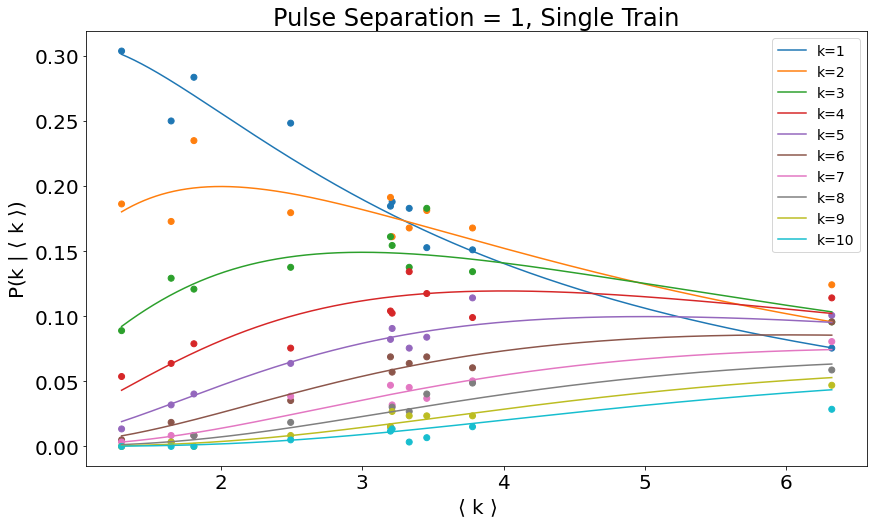

In [295]:
plt.figure()
plt.scatter(x.ravel(), y.ravel(), c=[f'C{k_-1}' for k_ in k.ravel()])

for kk in np.arange(min_k, max_k + 1):
    fit = neg_binom(xx, kk, out.best_values['M'])
    plt.plot(xx, fit, label=f'k={kk}')
    
plt.title(f'Pulse Separation = {pulse_separation}, Single Train')
plt.xlabel(r'$\langle$ k $\rangle$')
plt.ylabel(r'P(k | $\langle$ k $\rangle$)')
plt.legend(fontsize=14)
plt.show()

In [296]:
model = Model(neg_binom, independent_vars=['k_bar', 'k'])
params = Parameters()
params.add('M', value=4, min=0.1, max=150)
min_k = 1
max_k = 10

delays = []
contrasts = []
for p_sep, pulse_separation in tqdm(enumerate(range(len(train))), total=len(train), desc='Fitting Neg. Binom.'):
    y = prob_all[pulse_separation, min_k:max_k+1, :]
    x = np.repeat(np.expand_dims(k_bar_all[pulse_separation, :], axis=-1), len(y), axis=-1).T
    k = np.outer(np.arange(min_k, max_k+1), np.ones(len(y.T))).astype(int)

    if np.isnan(y).all():
        continue

    out = model.fit(data=y, k_bar=x, k=k, **params, nan_policy='omit')
    delays.append(p_sep)
    contrasts.append(1/np.sqrt(out.best_values['M']))

Fitting Neg. Binom.:   0%|          | 0/200 [00:00<?, ?it/s]

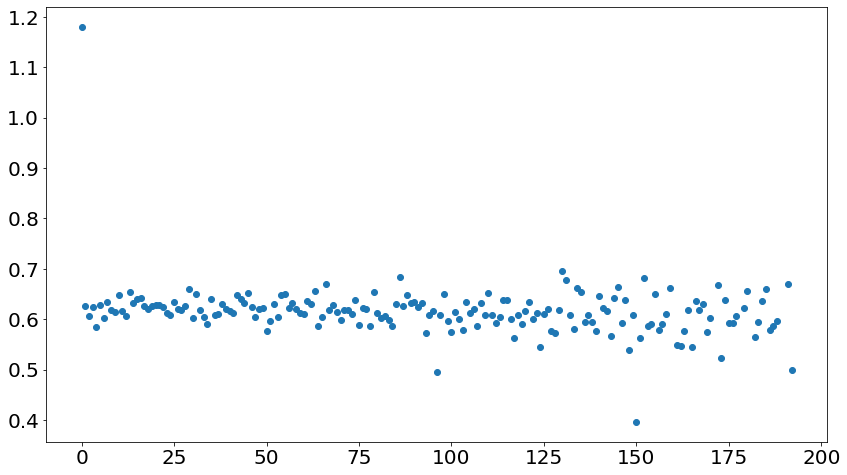

In [297]:
plt.plot(delays, contrasts, 'o')